<a href="https://colab.research.google.com/github/hariprasath1291/personal-site/blob/master/SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. IMPORTING REQUIRED LIBRARIES

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 pip install cmake 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!nvidia-smi

Sat Feb 25 06:25:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image

K.clear_session()

In [8]:
train_folder = "/content/drive/MyDrive/IsIc dataset/train/"
test_folder = "/content/drive/MyDrive/IsIc dataset/test/"

In [9]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 300 files in malignant
There are 360 files in benign


In [10]:
# 2. PREPROCESSING

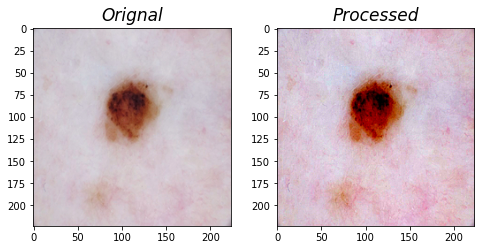

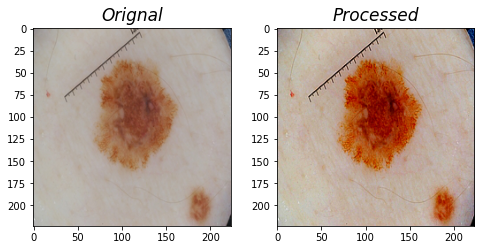

In [11]:

image_folder="malignant"  
number_of_images=2     

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(8,8))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.5', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.5', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

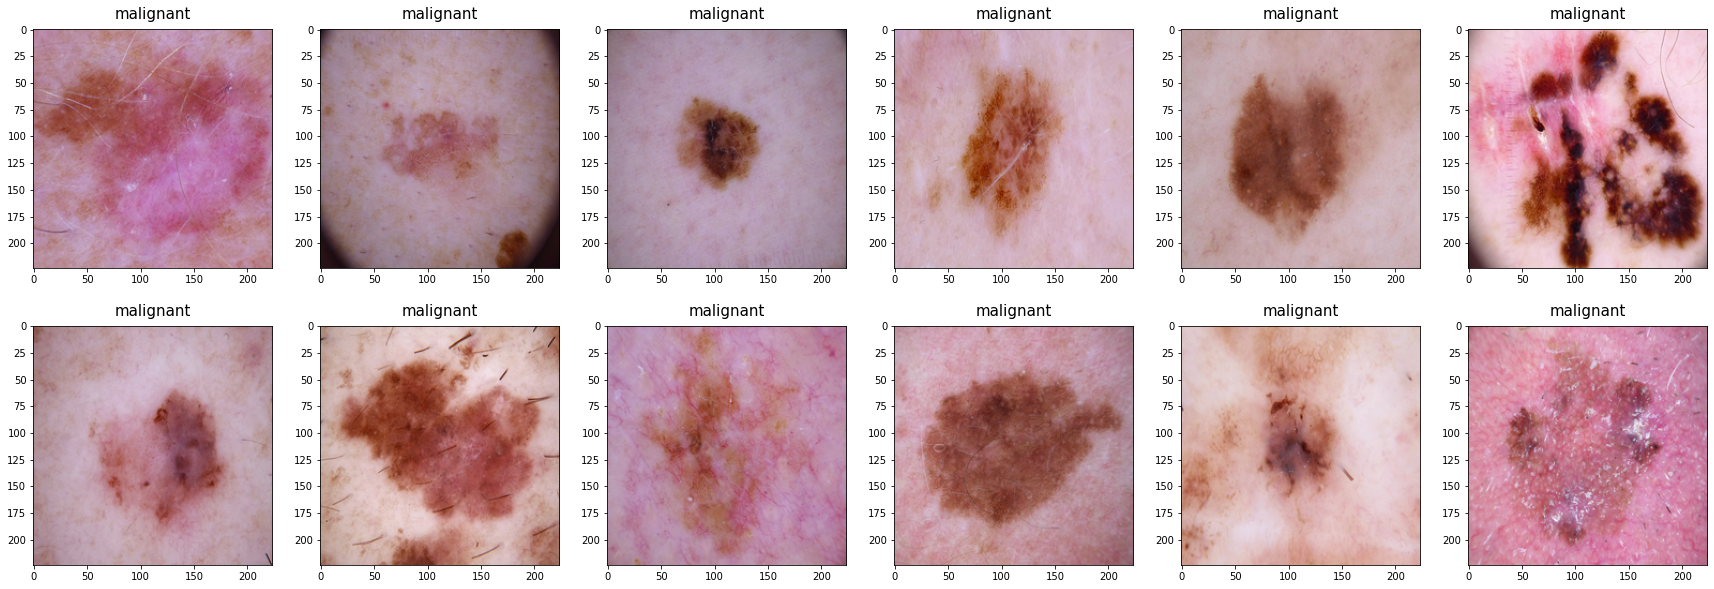

In [12]:
select_folder="malignant"
rows,columns = 2,6

display_folder=os.path.join(train_folder,select_folder)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_folder,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_folder, pad = 10, size=15)
    plt.imshow(img)
    
    if i==total_images-1:
        break

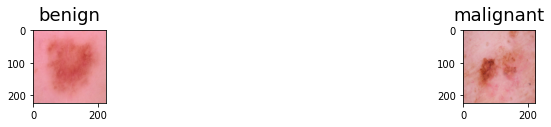

In [13]:
images = []

for image_folder in sorted(os.listdir(train_folder)):
    leaf = os.listdir(train_folder + '/' + image_folder)
    img_selected = np.random.choice(leaf)
    images.append(os.path.join(train_folder,image_folder,img_selected))
                                     
fig=plt.figure(1, figsize=(30, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(7, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

In [14]:
n_cat =2

batch_size = 48
batch_size_predict = 128
input_shape = (299,299)

In [15]:
#3. MODEL BUILDING

In [16]:
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

83683744/83683744 [==============================] - 3s 0us/step


In [17]:
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False   
    
x_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [18]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

In [19]:
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 lambda (Lambda)             (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [20]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 model (Functional)          (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 11,634,410
Non-trainable params: 9,231,168
_________________________________________________________________


In [21]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [22]:

train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (299, 299),
    color_mode="rgb",
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (299, 299),
    color_mode="rgb",
    batch_size = 48, 
    class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [23]:
class_map = training_set.class_indices
class_map

{'benign': 0, 'malignant': 1}

In [25]:
Model = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
55/55 [==============================] - 86s 2s/step - loss: 0.0313 - accuracy: 0.9909 - val_loss: 0.5416 - val_accuracy: 0.8818
Epoch 2/30
55/55 [==============================] - 86s 2s/step - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0.4835 - val_accuracy: 0.8773
Epoch 3/30
55/55 [==============================] - 84s 2s/step - loss: 0.0287 - accuracy: 0.9905 - val_loss: 0.4420 - val_accuracy: 0.8924
Epoch 4/30
55/55 [==============================] - 86s 2s/step - loss: 0.0487 - accuracy: 0.9833 - val_loss: 0.5656 - val_accuracy: 0.8606
Epoch 5/30
55/55 [==============================] - 83s 2s/step - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.7083 - val_accuracy: 0.8788
Epoch 6/30
55/55 [==============================] - 82s 1s/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.7207 - val_accuracy: 0.8955
Epoch 7/30
55/55 [==============================] - 84s 2s/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.4093 - val_accuracy: 0.9015
Epoch 8/30
55/55 [==

In [26]:
# 4. ACCURACY SCORE PLOT

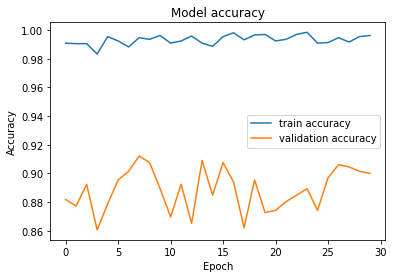

In [27]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

plot_accuracy(Model)

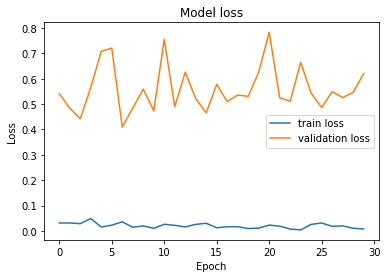

In [28]:
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    

plot_loss(Model)

In [29]:
# Using the test dataset
score = model.evaluate(test_set,batch_size=128)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 [==============================] - 6s 397ms/step - loss: 0.6208 - accuracy: 0.9000
Test loss: 0.6207773089408875
Test accuracy: 0.8999999761581421


In [30]:
validation_data_dir = '/content/drive/MyDrive/IsIc dataset/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 660 images belonging to 2 classes.
Test Accuracy: 0.900


In [31]:
category={
    0:'benign',1:'malignant'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

1/1 [==============================] - 2s 2s/step


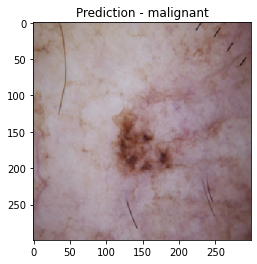

In [32]:
predict_image(os.path.join(validation_data_dir,'malignant/1027.jpg'),model)

1/1 [==============================] - 0s 30ms/step


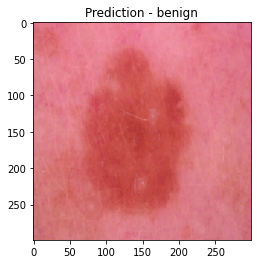

In [33]:
predict_image(os.path.join(validation_data_dir,'benign/1042.jpg'),model)

In [34]:
# 5. CONFUSION MATRIX

In [35]:
def labels_confusion_matrix(test_folder):
    
    folder_path=test_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) 
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) 

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 28ms/step


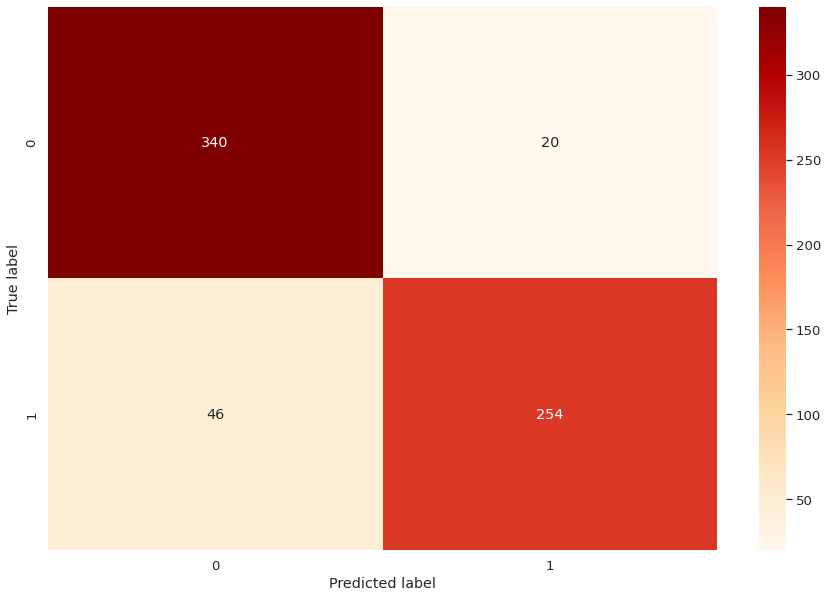

In [36]:
y_true,y_pred=labels_confusion_matrix(test_folder)
print_confusion_matrix(y_true,y_pred)